In [2]:

#import matplotlib.pyplot as plt
import os
import torch
from src.rgcn_explainer_utils import *
import pandas as pd
import numpy as np
import src.kgbench as kg

/usr/local/Caskroom/miniconda/base/envs/RGCNExplainer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Check if the current directory is already the parent directory
if current_dir != '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer':
    # Set the parent directory as the current directory
    os.chdir(parent_dir)
!pwd

/Users/macoftraopia/Documents/GitHub/RGCN-Explainer


In [4]:
from src.rgcn_explainer_utils import *
name = 'aifb'
if name in ['aifb', 'mutag', 'bgs', 'am', 'mdgenre']:
    data = kg.load(name, torch=True, final=False)
if 'IMDb' in name:    
    data = torch.load(f'data/IMDB/finals/{name}.pt')
if 'dbo' in name:
    data = torch.load(f'data/DBO/finals/{name}.pt')
relations = get_relations(data)
dict_classes = d_classes(data)
data.triples = torch.Tensor(data.triples).to(int)
data.withheld = torch.Tensor(data.withheld).to(int)
data.training = torch.Tensor(data.training).to(int)
print('rel:', data.num_relations, 'ent:', data.num_entities, 'triples:', data.triples.shape)
print('training', data.training.shape, 'withheld', data.withheld.shape)

loaded data aifb (0.2137s).
rel: 45 ent: 8285 triples: torch.Size([29043, 3])
training torch.Size([103, 2]) withheld torch.Size([35, 2])


In [ ]:
# filename = 'data/IMDB/imdb_onegenre.nt'
# output_filename = 'data/IMDB/imdb_onegenre_.nt'
# literal_rel = pd.read_csv('IMDB_relation_literal.csv')
# literal_rel = literal_rel['relation'].tolist()

# with open(filename, 'r') as file, open(output_filename, 'w') as output:
#     for line in file:
#         for i in literal_rel:
#          if i not in line:
#             output.write(line)
# literal_rel = pd.read_csv('IMDB_relation_literal.csv')
# literal_rel = literal_rel['relation'].tolist()
# print(literal_rel)

In [77]:

from matplotlib import legend
from networkx import spring_layout




def connect_minimally(disconnected_triples, guideline_triples):
    G = nx.Graph()
    G.add_edges_from([(int(u), int(v), {'weight': label}) for u, label, v in disconnected_triples])
    
    is_connected = nx.is_connected(G)
    
    if not is_connected:
        disconnected_nodes = {u for u, _, _ in disconnected_triples} | {v for _, _, v in disconnected_triples}
        subgraph = nx.Graph([(int(u), int(v), {'weight': label}) for u, label, v in guideline_triples if int(u) in disconnected_nodes and int(v) in disconnected_nodes])
        min_spanning_tree = nx.minimum_spanning_tree(subgraph)
        G.add_edges_from(min_spanning_tree.edges(data=True))
    
    return G

def extract_node_label(node_value):
    if 'http' in node_value:
        split_result = node_value.split('/')
        if len(split_result) >= 4:
            if '#' in node_value:
                return split_result[3].split('#')[0]
            else:
                return split_result[3]
    return 'blank'


def visualize_new(node_idx,data,init, masked_ver,masked_hor, result_weights=True, low_threshold=False,experiment_name=None, selected_visualization=True, connected_subgraph = True,make_connected=False):
    """ 
    Visualize important nodes for node idx prediction
    """
    name = data.name
    n_hop = 2
    threshold = 0.5

    if selected_visualization:
        sel_masked_ver, sel_masked_hor = sub_sparse_tensor(masked_ver, threshold,data, low_threshold),sub_sparse_tensor(masked_ver, threshold,data, low_threshold)

    else:
        sel_masked_ver, sel_masked_hor = masked_ver, masked_ver
    if len(sel_masked_ver)==0:
        sel_masked_ver=sub_sparse_tensor(masked_ver, 0,data, low_threshold)
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    
    G = nx.Graph()
    if result_weights: #the edge value is the mask weight       
        G.add_edges_from([(int(s), int(o), {'weight': np.round(p, 2)}) for s, p, o in zip(indices_nodes[0], sel_masked_ver.coalesce().values().tolist(), indices_nodes[1])])

    else: #the edge value is the relation
        triples_matched = match_to_triples(sel_masked_ver,sel_masked_hor, data)
        G.add_edges_from([(int(s), int(o), {'weight': p}) for s, p, o in find_repeating_sublists(triples_matched.tolist())])

    if connected_subgraph:
        G = G.subgraph(next(comp for comp in nx.connected_components(G) if node_idx in comp))

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = [list(set([item] if not isinstance(item, list) else item)) for item in weights]

    ordered_dict = {}
    for node in G.nodes:
        node_value = str(data.i2e[int(node)])
        node_label = extract_node_label(node_value)
        ordered_dict[int(node)] = node_label
        


    dict_node_color = {k: data.entities_classes[v] if v in data.entities_classes else 0 for k, v in ordered_dict.items()} 
    dict_node_color[node_idx] = 7
    labeldict = {int(node): int(node) for node in G.nodes}
    pos = nx.circular_layout(G)

    
    if make_connected:
        disconnected_triples = [[i[0], j[0], i[1]] for i, j in zip(edges, weights)] + [[i[0], j[1], i[1]] for i, j in zip(edges, weights) if len(j) > 1]; guideline_triples = data.triples.tolist()
        G = connect_minimally(disconnected_triples, guideline_triples)
        G = G.subgraph(next(comp for comp in nx.connected_components(G) if node_idx in comp))
        edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
        labeldict = {int(node): int(node) for node in G.nodes}
        if name == 'dbo_gender' :
            labeldict = {int(node): str(data.i2e[int(node)]).split('/')[-1].split(',')[0] for node in G.nodes}

            
        rel = {k: [v] for k, v in nx.get_edge_attributes(G, 'weight').items()}
        rel = {k: [data.i2rel[item][0] for item in v] if isinstance(v, list) else data.i2rel[v][0] for k, v in rel.items()}

        pos = nx.spring_layout(G,seed=42)
            
        min_x = min(pos[node][0] for node in pos)
        max_x = max(pos[node][0] for node in pos)
        shift = (max_x - min_x) * 0.05  # Adjust the value 0.05 to control the shift amount
        for node in pos:
            if pos[node][0] == max_x:
                pos[node] = (pos[node][0] - shift, pos[node][1])

        col_weights = [weights[i] for i in range(len(weights))]

        color_map = plt.cm.get_cmap('prism')
        colors = [color_map(col_weights[i]) for i in range(len(col_weights))]
        label_colors = {data.i2rel[i][0]:j for i,j in zip(col_weights,colors)}
        legend_elements = []
       
        for label, color in label_colors.items():
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))
        legend_elements1 = []
        cmap = plt.cm.get_cmap('tab20')
        mapped_dict2 = {key: cmap(value) for key, value in dict_node_color.items()}
        combined_dict = {ordered_dict[key]: value for key, value in mapped_dict2.items() if key in ordered_dict}
        for label, color in combined_dict.items():
            legend_elements1.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))



        node_colors = [mapped_dict2[i]  if i in mapped_dict2 else cmap(0) for i in G.nodes]
        edge_color=[label_colors[data.i2rel[i][0]] for i in col_weights]
        return G, pos, labeldict, edges, node_colors, edge_color,legend_elements, legend_elements1
        
    if result_weights==False and make_connected==False:
        col_weights = [sum(weights[i]) if len(weights[i]) > 1 else weights[i][0] for i in range(len(weights))]

        rel = {k: [data.i2rel[item][0] for item in v] if isinstance(v, list) else data.i2rel[v][0] for k, v in {k: list(set(v)) for k, v in nx.get_edge_attributes(G, 'weight').items()}.items()}
        color_map = plt.cm.get_cmap('prism')
        colors = [color_map(col_weights[i]) for i in range(len(col_weights))]
        label_colors = {data.i2rel[i][0]:j for i,j in zip(col_weights,colors)}

        legend_elements = []

        for label, color in label_colors.items():
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))
        legend_elements1 = []
        cmap = plt.cm.get_cmap('tab20')
        mapped_dict2 = {key: cmap(value) for key, value in dict_node_color.items()}
        combined_dict = {ordered_dict[key]: value for key, value in mapped_dict2.items() if key in ordered_dict}
        for label, color in combined_dict.items():
            legend_elements1.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))



        node_colors = [mapped_dict2[i]  if i in mapped_dict2 else cmap(0) for i in G.nodes]
        edge_color = [label_colors[data.i2rel[i][0]] for i in col_weights]


        return G, pos, labeldict, edges, node_colors, edge_color,legend_elements, legend_elements1





tensor(15)
tensor(56)
tensor(34)
tensor(56)
tensor(56)
tensor(56)


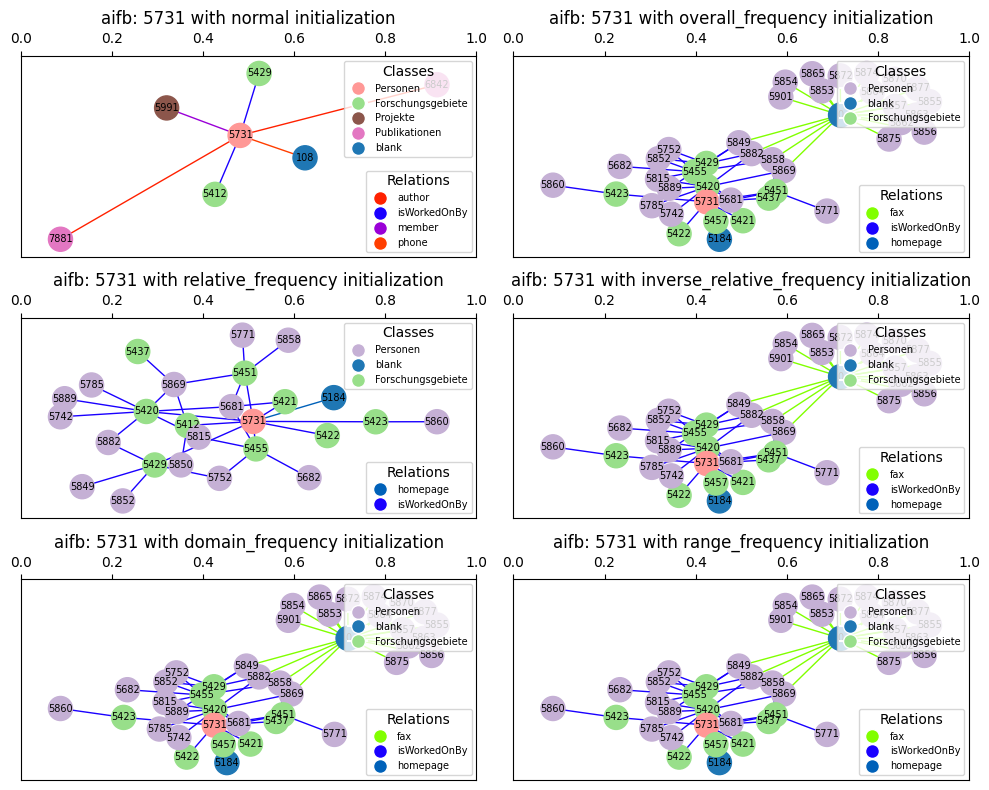

In [78]:
inits = ['normal', 'overall_frequency', 'relative_frequency', 'inverse_relative_frequency', 'domain_frequency', 'range_frequency']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))

for init, ax in zip(inits, axes.flatten()):
    node_idx = 5731
    path = f'chk/{name}_chk/exp/init_{init}_lr_0.5_size_0.0005_ent_1_type_1_wd_0.9_MFR_1/masked_adj'
    v = torch.load(f'{path}/masked_ver_thresh{node_idx}')
    h = torch.load(f'{path}/masked_hor_thresh{node_idx}')
    print(v.coalesce().values().count_nonzero())
    h_t, v_t,t,t = threshold_mask(h,v,data,15)
    G, pos, labeldict, edges, node_colors, edge_color, legend_elements, legend_elements1 = visualize_new(node_idx, data, init, v_t, h_t, result_weights=False, low_threshold=False, experiment_name=None, selected_visualization=True, connected_subgraph=True, make_connected=True)

    nx.draw(G, pos, labels=labeldict, edgelist=edges, node_color=node_colors, font_size=7, arrows=True, edge_color=edge_color, ax=ax)

    ax.legend(handles=legend_elements, loc='lower right', title='Relations', fontsize=7)
    ax_twiny = ax.twiny()  # Create a new axes sharing the y-axis with the original one
    ax_twiny.legend(handles=legend_elements1, title='Classes', loc='upper right', fontsize=7)
    ax.set_title(f"{data.name}: {node_idx} with {init} initialization")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


tensor(16)


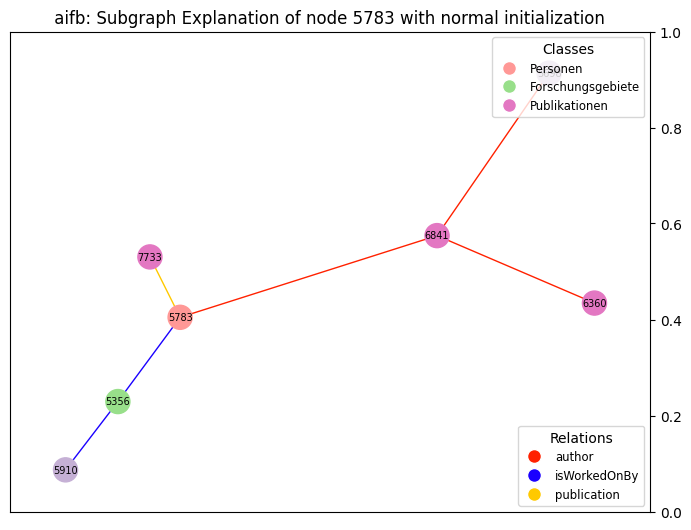

tensor(15)


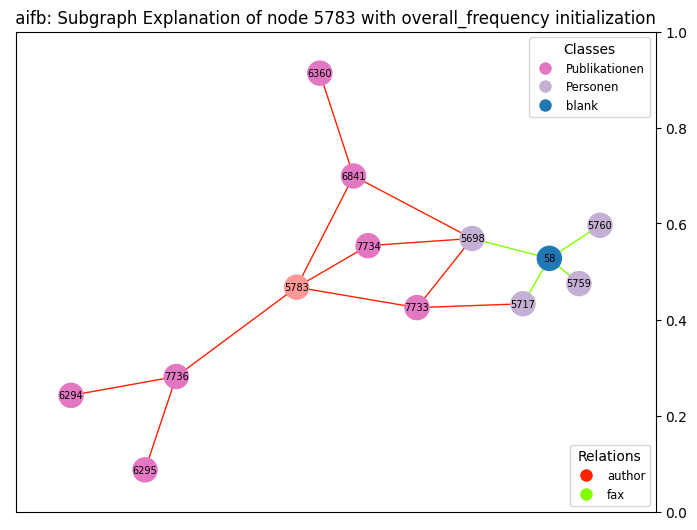

tensor(15)


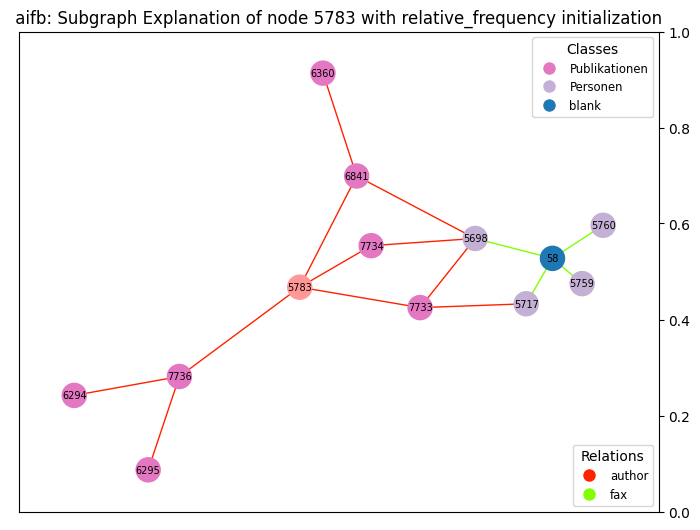

tensor(15)


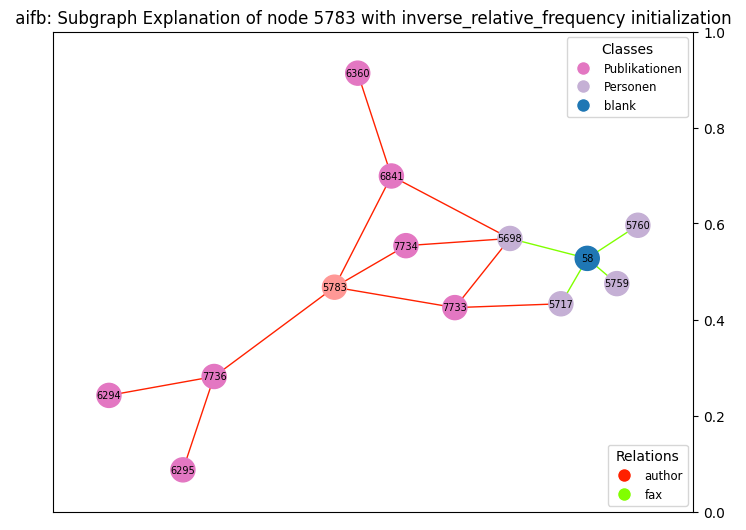

tensor(15)


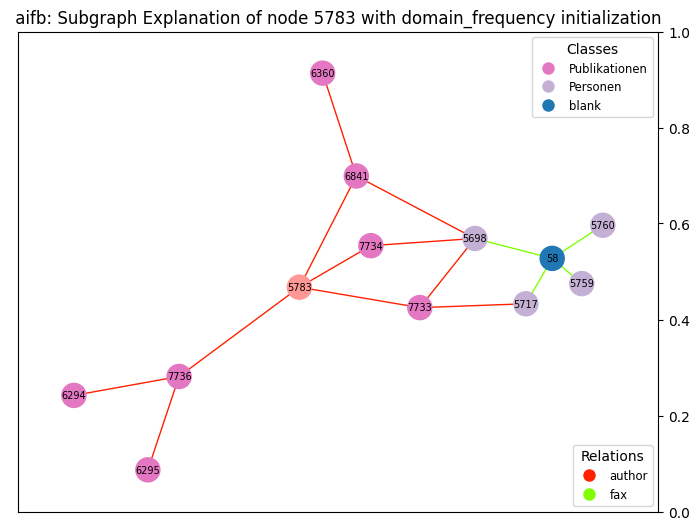

tensor(15)


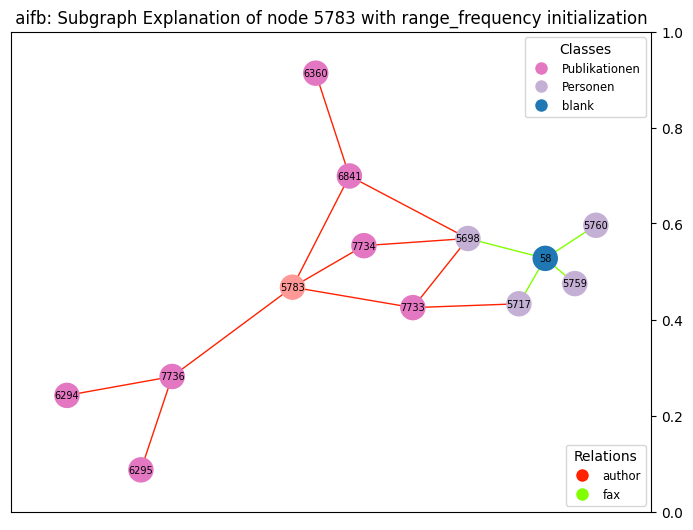

tensor(15)


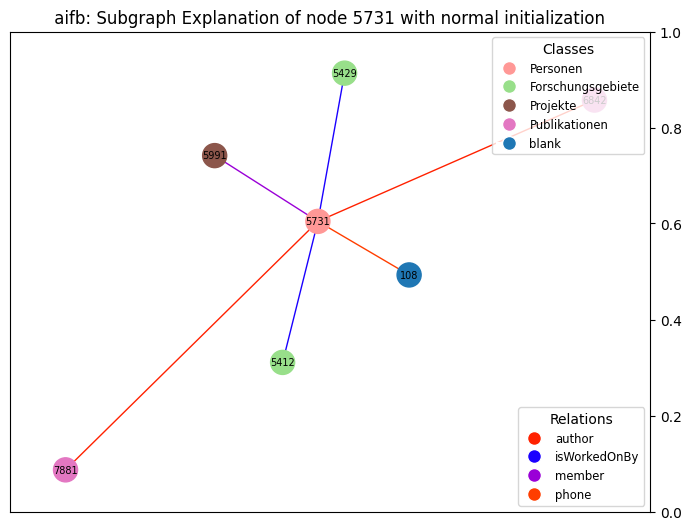

tensor(56)


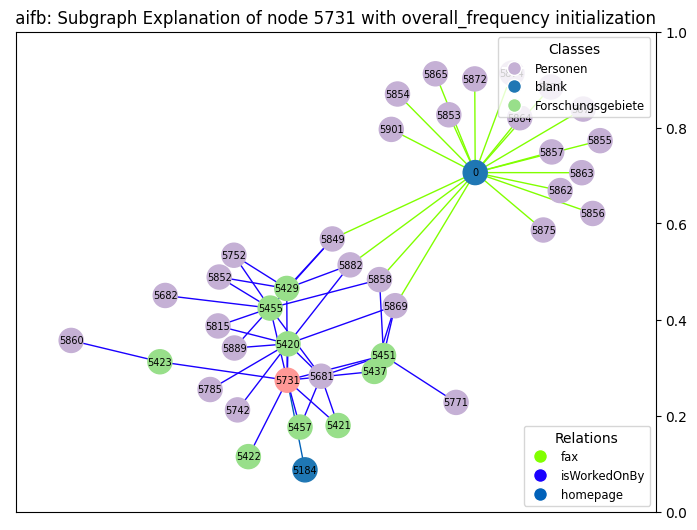

tensor(34)


KeyboardInterrupt: 

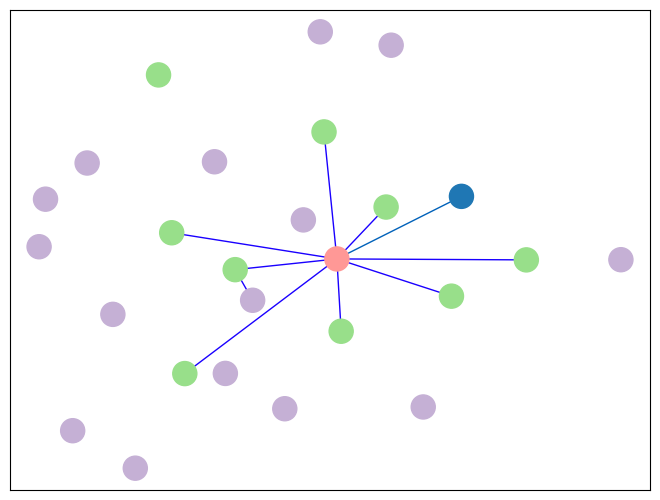

In [54]:
import random
inits =  ['normal', 'overall_frequency', 'relative_frequency', 'inverse_relative_frequency', 'domain_frequency', 'range_frequency']
random.seed(42)
sampled_nodes = []
for key in dict_classes:
    sampled_nodes.extend(random.sample(dict_classes[key], 1))

for node_idx in sampled_nodes:
    for init in inits:

        path = f'chk/{name}_chk/exp/init_{init}_lr_0.5_size_0.0005_ent_1_type_1_wd_0.9_MFR_1/masked_adj'
        
        name = data.name
        v = torch.load(f'{path}/masked_ver_thresh{node_idx}')
        h = torch.load(f'{path}/masked_hor_thresh{node_idx}')
        print(v.coalesce().values().count_nonzero())
        h_t, v_t,t,t = threshold_mask(h,v,data,15)
        #h_t, v_t = convert_binary(h), convert_binary(v)

        edges, weights = visualize(node_idx, data,init,  v_t,h_t,result_weights=False, low_threshold=False,experiment_name=None, selected_visualization=True,connected_subgraph=True,make_connected=True)
        
        


loaded data aifb (0.2981s).
{'AllgMA': 0, 'AtanasKiryakov': 1, 'BIK': 2, 'CoM': 3, 'EffAlg': 4, 'Forschungsgebiete': 5, 'Forschungsgruppen': 6, 'Kooperationen': 7, 'Ontoagents': 8, 'Personen': 9, 'Projekte': 10, 'Publications': 11, 'Publikationen': 12, 'Users': 13, 'WBS': 14, 'about': 15, 'ath': 16, 'auslese': 17, 'blaschke': 18, 'bpem': 19, 'cms': 20, 'docs': 21, 'eOrganisation': 22, 'english': 23, 'fbe': 24, 'fmricci': 25, 'home': 26, 'ia': 27, 'kangal': 28, 'mitarbeiter': 29, 'optrek': 30, 'padlr': 31, 'people': 32, 'personen': 33, 'projects': 34, 'projekte': 35, 'prost': 36, 'seanb': 37, 'semanticportal': 38, 'sites': 39, 'uli': 40, 'users': 41, 'valencia': 42, 'who': 43, 'wiki': 44, 'wim': 45, 'ze': 46}
tensor(28)
ordered dict {6881: 'Publikationen', 5678: 'Personen', 5743: 'Personen', 6981: 'Publikationen', 5745: 'Personen', 7045: 'Publikationen', 7100: 'Publikationen', 5746: 'Personen', 7393: 'Publikationen', 5747: 'Personen', 7968: 'Publikationen', 6404: 'Publikationen', 8013: 

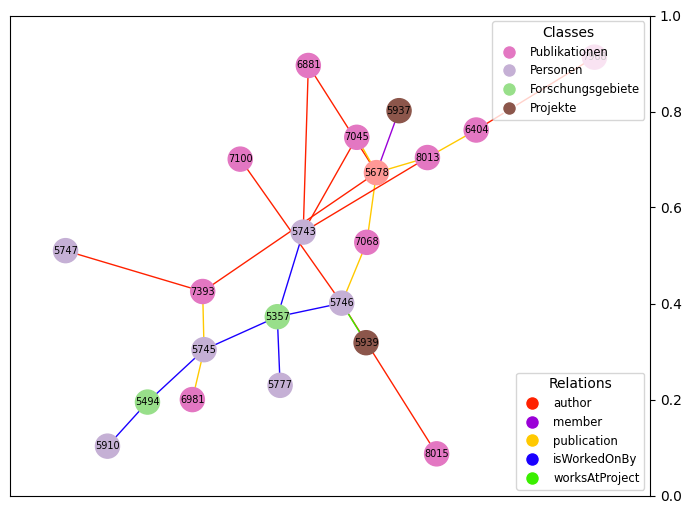

all the shown nodea are in the 2 hops neighborhood of node ix True


<Figure size 640x480 with 0 Axes>

In [145]:
path = 'chk/aifb_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj'
path = v = '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.0005_sizestd_adaptive_ent_10_type_10_killtype_True_break_no/masked_adj'
path = '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_1_type_1_killtype_True_break_no/masked_adj'
node_idx = 5678
n_hop = 2
threshold = 0.5
name = 'aifb'
data = kg.load(name, torch=True)
d_classes(data)



# path = 'chk/mutag_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.0005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj'

# node_idx = 22607#14064#4510
# n_hop = 2
# threshold = 0.5
# name = 'mutag'
# data = kg.load(name, torch=True)
# d_classes(data)


# name = 'dbo_gender'
# path = f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/exp/exp/init_normal_hops_2_lr_0.1_adaptive_False_size_0.0005_sizestd_adaptive_ent_1_type_1_killtype_False_break_no/masked_adj'
# path = 'chk/dbo_gender_chk/exp/init_normal_hops_2_lr_0.1_adaptive_False_size_0.0005_sizestd_adaptive_ent_1_type_1_killtype_False_break_no/masked_adj'
# node_idx = 7130 #7823#7130
# n_hop = 2
# threshold = 0.5
# data = torch.load(f'data/DBO/finals/{name}.pt')
# data.triples = torch.Tensor(data.triples).to(int)
# data.withheld = torch.Tensor(data.withheld).to(int)
# data.training = torch.Tensor(data.training).to(int)
# d_classes(data)


# path = 'chk/IMDb_us_chk/hops_2_size_5e-05_lr_0.1_ent_1_killtype_False_init_normal_exp__break_wrong_pred/masked_adj'
# path = 'chk/IMDb_us_chk/exp/init_relative_frequency_hops_2_lr_0.5_adaptive_False_size_0.0005_sizestd_adaptive_ent_10_type_1_killtype_False_break_no/masked_adj'
# path = 'chk/IMDb_us_chk/exp/init_normal_hops_2_lr_0.1_adaptive_False_size_0.0005_sizestd_adaptive_ent_1_type_1_killtype_True_break_no/masked_adj'
# node_idx = 9552#9547
# n_hop = 2
# threshold = 0.5
# name = 'IMDb_us'
# data = torch.load(f'data/IMDB/finals/{name}.pt')
# data.triples = torch.Tensor(data.triples).to(int)
# data.withheld = torch.Tensor(data.withheld).to(int)
# data.training = torch.Tensor(data.training).to(int)
# d_classes(data,'IMDb_us')

# path = 'chk/mdgenre_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj'
# node_idx = 184805
# n_hop = 2
# threshold = 0.5
# name = 'mdgenre'
# #data = kg.load(name, torch=True)
# #d_classes(data)


v = torch.load(f'{path}/masked_ver_thresh{node_idx}')
h = torch.load(f'{path}/masked_hor_thresh{node_idx}')
print(v.coalesce().values().count_nonzero())
h_t, v_t,t,t = threshold_mask(h,v,data,15)
#h_t, v_t = convert_binary(h), convert_binary(v)

edges, weights = visualize(node_idx, n_hop, data, v_t,h_t,threshold,name, result_weights=False, low_threshold=False,experiment_name=None, selected_visualization=True,connected_subgraph=True,make_connected=True)


sub_edges, neighborhoods, sub_edges_tensor  = find_n_hop_neighbors(data,2,node_idx,adj=True)
neighborhoods_list = list(neighborhoods)
edges_list = [item for tuple_ in edges for item in tuple_]
def are_all_elements_in_bigger_list(sublist, bigger_list):
    for element in sublist:
        if element not in bigger_list:
            return False
    return True
print('all the shown nodea are in the 2 hops neighborhood of node ix',are_all_elements_in_bigger_list(edges_list, neighborhoods_list))

loaded data aifb (0.2523s).
tensor(28)
ordered dict {6881: 'Publikationen', 5678: 'Personen', 5743: 'Personen', 6981: 'Publikationen', 5745: 'Personen', 7045: 'Publikationen', 7100: 'Publikationen', 5746: 'Personen', 7393: 'Publikationen', 5747: 'Personen', 7968: 'Publikationen', 6404: 'Publikationen', 8013: 'Publikationen', 8015: 'Publikationen', 5357: 'Forschungsgebiete', 5777: 'Personen', 5494: 'Forschungsgebiete', 5910: 'Personen', 5937: 'Projekte', 7068: 'Publikationen', 5939: 'Projekte'}
dict node color {6881: 12, 5678: 7, 5743: 9, 6981: 12, 5745: 9, 7045: 12, 7100: 12, 5746: 9, 7393: 12, 5747: 9, 7968: 12, 6404: 12, 8013: 12, 8015: 12, 5357: 5, 5777: 9, 5494: 5, 5910: 9, 5937: 10, 7068: 12, 5939: 10}
colors [(1.0, 0.1296454183688629, 0.0, 1.0), (1.0, 0.1296454183688629, 0.0, 1.0), (1.0, 0.1296454183688629, 0.0, 1.0), (0.602178932122292, 0.0, 0.8449672790322316, 1.0), (1.0, 0.7874868509602921, 0.0, 1.0), (1.0, 0.7874868509602921, 0.0, 1.0), (1.0, 0.7874868509602921, 0.0, 1.0), (1

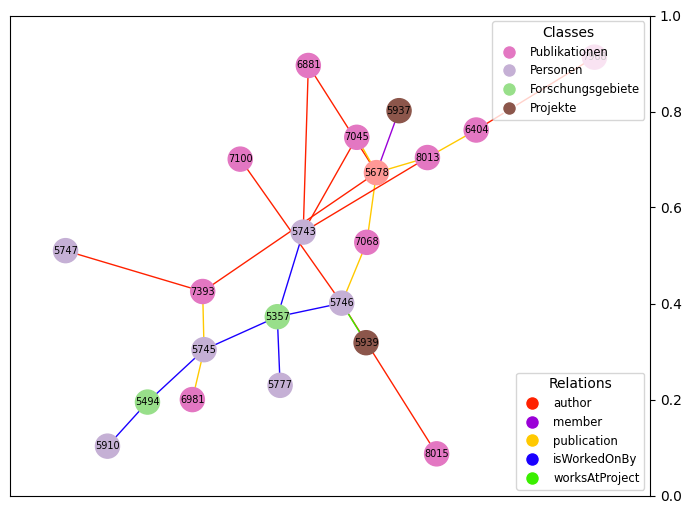

all the shown nodea are in the 2 hops neighborhood of node ix True


<Figure size 640x480 with 0 Axes>

In [6]:
path = 'chk/aifb_chk/bro/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj'
path = v = '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/bro/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.0005_sizestd_adaptive_ent_10_type_10_killtype_True_break_no/masked_adj'
path = '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/bro/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_1_type_1_killtype_True_break_no/masked_adj'
node_idx = 5678
n_hop = 2
threshold = 0.5
name = 'aifb'
data = kg.load(name, torch=True)
d_classes(data)



# path = 'chk/mutag_chk/bro/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.0005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj'

# node_idx = 22607#14064#4510
# n_hop = 2
# threshold = 0.5
# name = 'mutag'
# data = kg.load(name, torch=True)
# d_classes(data)


# name = 'dbo_gender'
# path = f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/bro/exp/exp/init_normal_hops_2_lr_0.1_adaptive_False_size_0.0005_sizestd_adaptive_ent_1_type_1_killtype_False_break_no/masked_adj'
# path = 'chk/dbo_gender_chk/bro/exp/init_normal_hops_2_lr_0.1_adaptive_False_size_0.0005_sizestd_adaptive_ent_1_type_1_killtype_False_break_no/masked_adj'
# node_idx = 7130 #7823#7130
# n_hop = 2
# threshold = 0.5
# data = torch.load(f'data/DBO/finals/{name}.pt')
# data.triples = torch.Tensor(data.triples).to(int)
# data.withheld = torch.Tensor(data.withheld).to(int)
# data.training = torch.Tensor(data.training).to(int)
# d_classes(data)


# path = 'chk/IMDb_us_chk/hops_2_size_5e-05_lr_0.1_ent_1_killtype_False_init_normal_exp__break_wrong_pred/masked_adj'
# path = 'chk/IMDb_us_chk/bro/exp/init_relative_frequency_hops_2_lr_0.5_adaptive_False_size_0.0005_sizestd_adaptive_ent_10_type_1_killtype_False_break_no/masked_adj'
# path = 'chk/IMDb_us_chk/bro/exp/init_normal_hops_2_lr_0.1_adaptive_False_size_0.0005_sizestd_adaptive_ent_1_type_1_killtype_True_break_no/masked_adj'
# node_idx = 9552#9547
# n_hop = 2
# threshold = 0.5
# name = 'IMDb_us'
# data = torch.load(f'data/IMDB/finals/{name}.pt')
# data.triples = torch.Tensor(data.triples).to(int)
# data.withheld = torch.Tensor(data.withheld).to(int)
# data.training = torch.Tensor(data.training).to(int)
# d_classes(data,'IMDb_us')

# path = 'chk/mdgenre_chk/bro/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj'
# node_idx = 184805
# n_hop = 2
# threshold = 0.5
# name = 'mdgenre'
# #data = kg.load(name, torch=True)
# #d_classes(data)


v = torch.load(f'{path}/masked_ver_thresh{node_idx}')
h = torch.load(f'{path}/masked_hor_thresh{node_idx}')
print(v.coalesce().values().count_nonzero())
h_t, v_t,t,t = threshold_mask(h,v,data,15)
#h_t, v_t = convert_binary(h), convert_binary(v)

edges, weights = visualize(node_idx, n_hop, data, v_t,h_t,threshold,name, result_weights=False, low_threshold=False,experiment_name=None, selected_visualization=True,connected_subgraph=True,make_connected=True)


sub_edges, neighborhoods, sub_edges_tensor  = find_n_hop_neighbors(data,2,node_idx,adj=True)
neighborhoods_list = list(neighborhoods)
edges_list = [item for tuple_ in edges for item in tuple_]
def are_all_elements_in_bigger_list(sublist, bigger_list):
    for element in sublist:
        if element not in bigger_list:
            return False
    return True
print('all the shown nodea are in the 2 hops neighborhood of node ix',are_all_elements_in_bigger_list(edges_list, neighborhoods_list))

In [85]:
for i,j in zip(edges, weights):

    print(data.i2e[i[0]][0],',', data.i2r[j[0]],',', data.i2e[i[1]][0])
    if len(j) > 1:
        print(data.i2e[i[0]][0],',', data.i2r[j[1]],',', data.i2e[i[1]][0])

http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id102instance , http://swrc.ontoware.org/ontology#author , http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance , http://swrc.ontoware.org/ontology#author , http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id842instance
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance , http://swrc.ontoware.org/ontology#isWorkedOnBy , http://www.aifb.uni-karlsruhe.de/Forschungsgebiete/viewForschungsgebietOWL/id22instance
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance , http://swrc.ontoware.org/ontology#isWorkedOnBy , http://www.aifb.uni-karlsruhe.de/Forschungsgebiete/viewForschungsgebietOWL/id39instance
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance , http://swrc.ontoware.org/ontology#phone , +49 721 608-3924
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instan

In [143]:
sub_edges, neighborhoods, sub_edges_tensor  = find_n_hop_neighbors(data,2,node_idx,adj=True)
neighborhoods_list = list(neighborhoods)
edges_list = [item for tuple_ in edges for item in tuple_]
def are_all_elements_in_bigger_list(sublist, bigger_list):
    for element in sublist:
        if element not in bigger_list:
            return False
    return True
print(are_all_elements_in_bigger_list(edges_list, neighborhoods_list))


True


In [119]:
edges =  edge_index_oneadj(data.triples)
edges.t()

tensor([[4938, 8181],
        [4938, 8175],
        [4938, 5292],
        ...,
        [7628,  350],
        [7628, 5220],
        [8052, 8178]])

In [107]:
edges_list = [item for tuple_ in edges for item in tuple_]
print(edges_list)

[6881, 5678, 6881, 5743, 5678, 7393, 5678, 5937, 5678, 7045, 5678, 7068, 5678, 8013, 5743, 7045, 5743, 8013, 5743, 5357, 6981, 5745, 5745, 7393, 5745, 5357, 5745, 5494, 7100, 5746, 5746, 8015, 5746, 5357, 5746, 7068, 5746, 5939, 7393, 5747, 7968, 6404, 6404, 8013, 5357, 5777, 5494, 5910]


In [79]:
#dbogender
triples = []
for i,j in zip(edges, weights):

    #print(data.i2e[i[0]][0],',', data.i2r[j],',', data.i2e[i[1]][0])

    triples.append([data.i2e[i[0]][0], data.i2r[j], data.i2e[i[1]][0]])

    # if len(j) > 1:
    #     print(data.i2e[i[0]][0],',', data.i2r[j],',', data.i2e[i[1]][0])
triples

[['http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id28instance',
  'http://swrc.ontoware.org/ontology#fax',
  ''],
 ['http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id28instance',
  'http://swrc.ontoware.org/ontology#isWorkedOnBy',
  'http://www.aifb.uni-karlsruhe.de/Forschungsgebiete/viewForschungsgebietOWL/id39instance'],
 ['http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id28instance',
  'http://swrc.ontoware.org/ontology#isWorkedOnBy',
  'http://www.aifb.uni-karlsruhe.de/Forschungsgebiete/viewForschungsgebietOWL/id63instance'],
 ['',
  'http://swrc.ontoware.org/ontology#fax',
  'http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id32instance'],
 ['',
  'http://swrc.ontoware.org/ontology#fax',
  'http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id33instance'],
 ['',
  'http://swrc.ontoware.org/ontology#fax',
  'http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id34instance'],
 ['',
  'http://swrc.ontoware.org/ontology#fax',
  'http://www.a

In [69]:
data.i2e[22607]

('http://dl-learner.org/carcinogenesis#d133', 'none')

In [15]:

for i in data.withheld:
    if i[0] == node_idx:
        print(i)

tensor([6435,    0])


In [64]:
def generate_text(triples, instance_id):
    instance_info = {}
    for triple in triples:
        subject, predicate, obj = triple
        if subject == instance_id:
            if predicate not in instance_info:
                instance_info[predicate] = []
            instance_info[predicate].append(obj)
    
    text = f"Person with the ID \"{instance_id}\" is listed as an author in the following publications: {', '.join(instance_info.get('http://swrc.ontoware.org/ontology#author', []))}."

    for predicate, objects in instance_info.items():
        if predicate != "http://swrc.ontoware.org/ontology#author":
            if len(objects) == 1:
                text += f"\n\nIn \"{objects[0]}\", the person \"{instance_id}\" {predicate.split('/')[-1]}: \"{objects[0]}\"."
            else:
                text += f"\n\nMoreover, \"{objects[0]}\" has the following {predicate.split('/')[-1]}: {', '.join(objects[1:])}."

    fax_numbers = instance_info.get('http://swrc.ontoware.org/ontology#fax', [])
    if fax_numbers:
        text += f"\n\nFinally, \"{instance_id}\" has several fax numbers associated with them, including {', '.join(fax_numbers)}."

    return text


instance_id = "http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance"

output_text = generate_text(triples, instance_id)
print(output_text)


Person with the ID "http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance" is listed as an author in the following publications: http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id842instance, http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id445instance, http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id840instance.

In "http://www.aifb.uni-karlsruhe.de/Forschungsgebiete/viewForschungsgebietOWL/id65instance", the person "http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance" ontology#isWorkedOnBy: "http://www.aifb.uni-karlsruhe.de/Forschungsgebiete/viewForschungsgebietOWL/id65instance".

In "http://www.aifb.uni-karlsruhe.de/Personen/Bilder/U1p2l3o4a5d19", the person "http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance" ontology#photo: "http://www.aifb.uni-karlsruhe.de/Personen/Bilder/U1p2l3o4a5d19".

Moreover, "http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id102insta

In [62]:
def generate_text(triples, instance_id):
    instance_info = {}
    for triple in triples:
        subject, predicate, obj = triple
        if subject == instance_id:
            if predicate not in instance_info:
                instance_info[predicate] = []
            instance_info[predicate].append(obj)
    
    text = f"The person with the ID \"{instance_id}\""
    
    if "http://www.w3.org/1999/02/22-rdf-syntax-ns#type" in instance_info:
        text += f" is a {', '.join(instance_info['http://www.w3.org/1999/02/22-rdf-syntax-ns#type'])}."
    else:
        text += "."

    if "http://swrc.ontoware.org/ontology#author" in instance_info:
        text += f"\n\nThe person with the ID \"{instance_id}\" is listed as an author in the following publications: {', '.join(instance_info['http://swrc.ontoware.org/ontology#author'])}."
    
    if "http://swrc.ontoware.org/ontology#isWorkedOnBy" in instance_info:
        text += f"\n\nMoreover, the person \"{instance_id}\" is worked on by the following research areas: {', '.join(instance_info['http://swrc.ontoware.org/ontology#isWorkedOnBy'])}."
    
    if "http://swrc.ontoware.org/ontology#photo" in instance_info:
        text += f"\n\nThe person \"{instance_id}\" has a photo available at \"{instance_info['http://swrc.ontoware.org/ontology#photo'][0]}\"."
    
    # Add more patterns here for other predicates or relationships you want to include in the output text.

    return text

# Example usage:
# triples = [
#     ("http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id339instance", "http://swrc.ontoware.org/ontology#author", "http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id15instance"),
#     # Add more triples here as needed
# ]

instance_id = "http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance"

output_text = generate_text(triples, instance_id)
print(output_text)


The person with the ID "http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance".

The person with the ID "http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance" is listed as an author in the following publications: http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id842instance, http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id445instance, http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id840instance.

Moreover, the person "http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance" is worked on by the following research areas: http://www.aifb.uni-karlsruhe.de/Forschungsgebiete/viewForschungsgebietOWL/id65instance.

The person "http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance" has a photo available at "http://www.aifb.uni-karlsruhe.de/Personen/Bilder/U1p2l3o4a5d19".


In [8]:

def connect_minimally(disconnected_triples, guideline_triples):
    G = nx.Graph()

    # Add the disconnected triples as edges to the graph
    for u,label, v in disconnected_triples:
        G.add_edge(int(u), int(v), weight=label)

    # Check if the graph is connected
    is_connected = nx.is_connected(G)
    # If the graph is not connected
    if not is_connected:
        # Get the nodes from the disconnected triples
        disconnected_nodes = set()
        for triple in disconnected_triples:
            disconnected_nodes.add(triple[0])
            disconnected_nodes.add(triple[1])

        # Create a subgraph with only the guideline triples relevant to the disconnected nodes
        subgraph = nx.Graph()
        for u,label, v in guideline_triples:
            if u in disconnected_nodes and v in disconnected_nodes:
                subgraph.add_edge(int(u), int(v), weight=label)
            


        # Compute the minimum spanning tree of the subgraph
        min_spanning_tree = nx.minimum_spanning_tree(subgraph)

        # Add the edges from the minimum spanning tree to the graph
        for u, v, weight in min_spanning_tree.edges(data='weight'):
            G.add_edge(u, v, weight=weight)



    return G


def visualize(node_idx, n_hop, data, masked_ver,threshold,name, result_weights=True, low_threshold=False,experiment_name=None, selected_visualization=True, connected_subgraph = True,make_connected=False):
    """ 
    Visualize important nodes for node idx prediction
    """
    get_relations(data)
    dict_index = dict_index_classes(data,masked_ver)
    
    #select only nodes with a certain threshold
    if selected_visualization:
        sel_masked_ver = sub_sparse_tensor(masked_ver, threshold,data, low_threshold)
        sel_masked_hor = sub_sparse_tensor(masked_ver, threshold,data, low_threshold)
    else:
        sel_masked_ver = masked_ver
        sel_masked_hor = masked_ver
    if len(sel_masked_ver)==0:
        sel_masked_ver=sub_sparse_tensor(masked_ver, 0,data, low_threshold)
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) #original edge indexes

    
    
    G = nx.Graph()
    if result_weights:
        values = sel_masked_ver.coalesce().values().tolist()
        for s,p,o in zip(indices_nodes[0],values , indices_nodes[1]):
            G.add_edge(int(s), int(o), weight=np.round(p, 2))

    else:

        triples_matched = match_to_triples(sel_masked_ver,sel_masked_hor, data)
        l = []
        for i in triples_matched[:,1]:
            l.append(data.i2rel[int(i)][0])
        triples_matched = find_repeating_sublists(triples_matched.tolist())
        for s,p,o in triples_matched:
            G.add_edge(int(s), int(o), weight=p)
    if connected_subgraph:
        #conncected subgraph
        #add condition to take node of interest for the connected boy
        
        # connected_components = nx.connected_components(G)
        # component = next(connected_components)
        # G = G.subgraph(component)

        connected_components = nx.connected_components(G)

        component = None
        for comp in connected_components:
            if node_idx in comp:
                component = comp
                break

        if component is not None:
            # Extract the subgraph containing the specified node
            G = G.subgraph(component)

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = [[item] if not isinstance(item, list) else item for item in weights]
    weights = [list(set(w)) for w in weights]



    pos = nx.circular_layout(G)
    #pos = nx.spring_layout(G)

    ordered_dict = {}
    for item in list(G.nodes):

        if item in ordered_dict:
            ordered_dict[item].append(dict_index[item])

        # if item not in ordered_dict and item in dict_index:
        #     ordered_dict[item] =  dict_index[item]
        # if item not in dict_index:
        #     ordered_dict[item] = 100000


    dict_index = ordered_dict

    labeldict = {}
    for node in G.nodes:
        labeldict[int(node)] = int(node)  

    dict = {}
    for k,v in dict_index.items():
        for k1,v1 in data.entities_classes.items():
            if v==k1: 

                dict[k] = v1
                print(v1)
            else:
                if k not in dict:
                    dict[k] = 0
                

    color_list = list(dict.values())
    #color_list = list(encode_dict(dict_index).values())

    if make_connected:
        disconnected_triples = []
        for i,j in zip(edges, weights):
            disconnected_triples.append([i[0], j[0], i[1]])
            if len(j) > 1:
                disconnected_triples.append(i[0], j[1], i[1])
        guideline_triples = data.triples.tolist()

        G = connect_minimally(disconnected_triples, guideline_triples)
        edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
 

        pos = nx.spring_layout(G)
        re = nx.get_edge_attributes(G, 'weight')
        rel = {k: [v] for k, v in re.items()}

        for k, v in rel.items():
            if isinstance(v, list):
                updated_values = [data.i2rel[item][0] for item in v]
                rel[k] = updated_values
            else:
                rel[k] = data.i2rel[v][0]

        labeldict = {}
        for node in G.nodes:
            labeldict[int(node)] = int(node) 
        col_weights = [weights[i] for i in range(len(weights))]
        nx.draw(G, pos,labels = labeldict, edge_color=col_weights,edgelist=edges,node_color =  color_list, cmap="Set2",font_size=7, arrows = True)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=3,font_color='red')
    if result_weights:
        col_weights = [weights[i] for i in range(len(weights))]
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=col_weights, node_color =  color_list, cmap="Set2",edge_cmap=plt.cm.Reds,font_size=8)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=nx.get_edge_attributes(G,'weight'),font_size=8,font_color='red')
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array(weights)
        cbar = plt.colorbar(sm)
        cbar.ax.set_title('Weight')
        plt.title("Node {}'s {}-hop neighborhood important nodes".format(node_idx, n_hop))
    if result_weights==False and make_connected==False:
        col_weights = [sum(weights[i]) if len(weights[i]) > 1 else weights[i][0] for i in range(len(weights))]
        re = nx.get_edge_attributes(G, 'weight')
        if make_connected:
            rel = {k: [v] for k, v in re.items()}
        else:
            rel =  {k: list(set(v)) for k, v in re.items()}


        for k, v in rel.items():
            if isinstance(v, list):
                updated_values = [data.i2rel[item][0] for item in v]
                rel[k] = updated_values
            else:
                rel[k] = data.i2rel[v][0]

        col_weights = [sum(weights[i]) if len(weights[i]) > 1 else weights[i][0] for i in range(len(weights))]
        nx.draw(G, pos,labels = labeldict, edge_color=col_weights,edgelist=edges,node_color =  color_list, cmap="Set2",font_size=7, arrows = True)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=5,font_color='red')
        
        res = Counter(unnest_list(rel.values()))
    if result_weights:
        if not os.path.exists(f'chk/{name}_chk/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/{experiment_name}⁄graphs/Explanation_{node_idx}_weights.png')

        #plt.show()

    else:
        if not os.path.exists(f'chk/{name}_chk/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/{experiment_name}⁄graphs/Explanation_{node_idx}_relations.png')    
        #plt.show()
        return  edges, weights



